In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Equities', 'Foreign') + ['VT', 'ACWI'], 64, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-04-18 to 2019-07-19 - 77


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

25


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
EWZ,60,0.235946,0.676899,0.336843,15.190032,10.630581
RSX,60,0.144670,0.361690,0.378040,8.881732,5.962674
EWL,60,0.104851,0.278615,0.347844,6.955631,3.113807
EWA,60,0.087957,0.281650,0.284114,5.898750,3.321207
ILF,60,0.077436,0.505413,0.137509,3.522366,10.404973
VIGI,60,0.066218,0.270882,0.215154,3.330847,4.587566
EFAV,60,0.062782,0.195533,0.280494,3.662094,2.819624
EPP,60,0.057428,0.303148,0.163259,3.928803,4.599415
EFG,60,0.048827,0.295870,0.138205,2.872753,4.537548


evicted DEM 0.851 0.497
evicted EWH 0.890 0.283
evicted EPP 0.864 0.290
evicted HEFA 0.834 0.075
evicted VIGI 0.897 0.260
evicted EWC 0.836 0.153
evicted EFAV 0.884 0.214
evicted EWA 0.760 0.211
retry backlogs ['EFA', 'SPDW', 'EFG', 'GSIE', 'DBEF', 'FEZ', 'IEFA', 'IDEV', 'ILF', 'ACWI', 'RODM', 'IPAC', 'VT', 'FNDE'] at 0.905/-0.51 - 0.469
evicted FNDE 0.779 0.588
evicted DBEF 0.888 0.089
evicted RODM 0.804 0.199
retry backlogs ['VT', 'ILF', 'EFA', 'IEFA', 'SPDW', 'IDEV', 'FEZ', 'GSIE', 'IPAC', 'EFG', 'ACWI'] at 0.910/-0.52 - 0.469
evicted VT 0.726 0.222
retry backlogs ['SPDW', 'EFA', 'FEZ', 'IEFA', 'ACWI', 'EFG', 'ILF', 'IDEV', 'IPAC', 'GSIE'] at 0.915/-0.53 - 0.469
evicted GSIE 0.824 0.166
retry backlogs ['SPDW', 'EFA', 'FEZ', 'IEFA', 'EFG', 'ILF', 'IDEV', 'IPAC', 'ACWI'] at 0.920/-0.54 - 0.469
evicted ACWI 0.732 0.235
retry backlogs ['SPDW', 'IPAC', 'EFG', 'EFA', 'IEFA', 'FEZ', 'ILF', 'IDEV'] at 0.925/-0.55 - 0.469
evicted IDEV 0.804 0.193
retry backlogs ['SPDW', 'IPAC', 'EFG', 'EFA',

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,60.0,0.150443,0.302998,-0.618217,-0.041637,0.167254,0.367247,0.829415,0.470323,9.647298,4.078583
RSX,60.0,0.144670,0.361690,-0.702154,-0.058444,0.163147,0.431317,0.834201,0.378040,8.881732,5.962674
EWL,60.0,0.104851,0.278615,-0.471248,-0.090213,0.095524,0.302263,0.749619,0.347844,6.955631,3.113807
EWZ,60.0,0.235946,0.676899,-1.679113,-0.170307,0.165433,0.709951,1.449663,0.336843,15.190032,10.630581


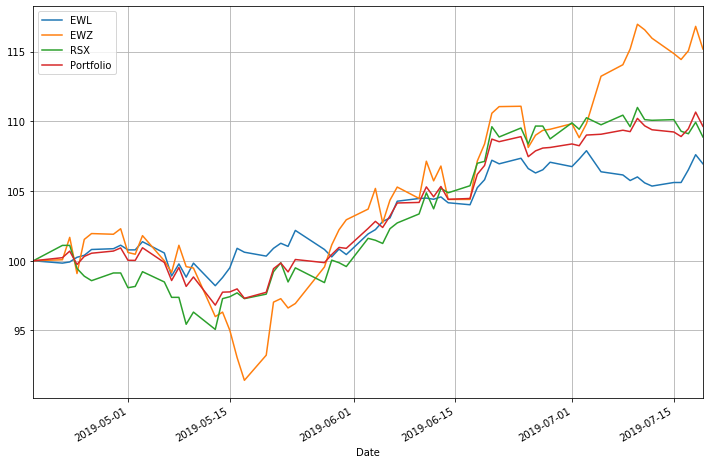

In [4]:
bounds = .12, .16
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(_lambda=1, bounds=bounds)
quote.setup_mask(['RSX', 'EWZ', 'EWL'])
sd.update(quote.optimize_portfolio(_lambda=1, bounds=bounds))
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(_lambda=1, bounds=bounds))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)